# 01 - Data Preprocessing

This notebook demonstrates the preprocessing pipeline for single-cell RNA-seq data.

## Overview

The preprocessing steps include:
1. Data loading
2. Quality control metrics calculation
3. Cell and gene filtering
4. Normalization
5. Highly variable gene identification
6. Dimensionality reduction (PCA)

## Setup

In [5]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yaml

# Configure scanpy
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80, facecolor='white')

# Set random seed for reproducibility
np.random.seed(42)

print(f"Scanpy version: {sc.__version__}")

C:\Users\dell\AppData\Local\Temp\ipykernel_15140\2348608299.py:15: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('scanpy')` instead
  print(f"Scanpy version: {sc.__version__}")


Scanpy version: 1.11.5


## Load Configuration

In [6]:
# Load configuration
with open('../config/analysis_config.yaml', 'r') as f:
    config = yaml.safe_load(f)

print("Configuration loaded successfully")
print(f"Min genes per cell: {config['preprocessing']['min_genes_per_cell']}")
print(f"Max mitochondrial %: {config['preprocessing']['max_mito_percent']}")

Configuration loaded successfully
Min genes per cell: 200
Max mitochondrial %: 10


## Load Data

Load your single-cell RNA-seq data. This example shows loading from different formats.

In [7]:
# Example 1: Load from 10X directory
# adata = sc.read_10x_mtx(
#     '../data/raw/sample1/',
#     var_names='gene_symbols',
#     cache=True
# )

# Example 2: Load from h5ad file
# adata = sc.read_h5ad('../data/raw/sample.h5ad')

# Example 3: Create toy dataset for demonstration
adata = sc.datasets.pbmc3k()

print(f"Data shape: {adata.shape[0]} cells x {adata.shape[1]} genes")
adata

try downloading from url
https://falexwolf.de/data/pbmc3k_raw.h5ad
... this may take a while but only happens once


  0%|          | 0.00/5.58M [00:00<?, ?B/s]

Data shape: 2700 cells x 32738 genes


AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

## Quality Control

Calculate QC metrics and visualize data quality.

In [8]:
# Identify mitochondrial genes
adata.var['mt'] = adata.var_names.str.startswith('MT-')

# Calculate QC metrics
sc.pp.calculate_qc_metrics(
    adata, 
    qc_vars=['mt'], 
    percent_top=None, 
    log1p=False, 
    inplace=True
)

print("QC metrics calculated")

QC metrics calculated


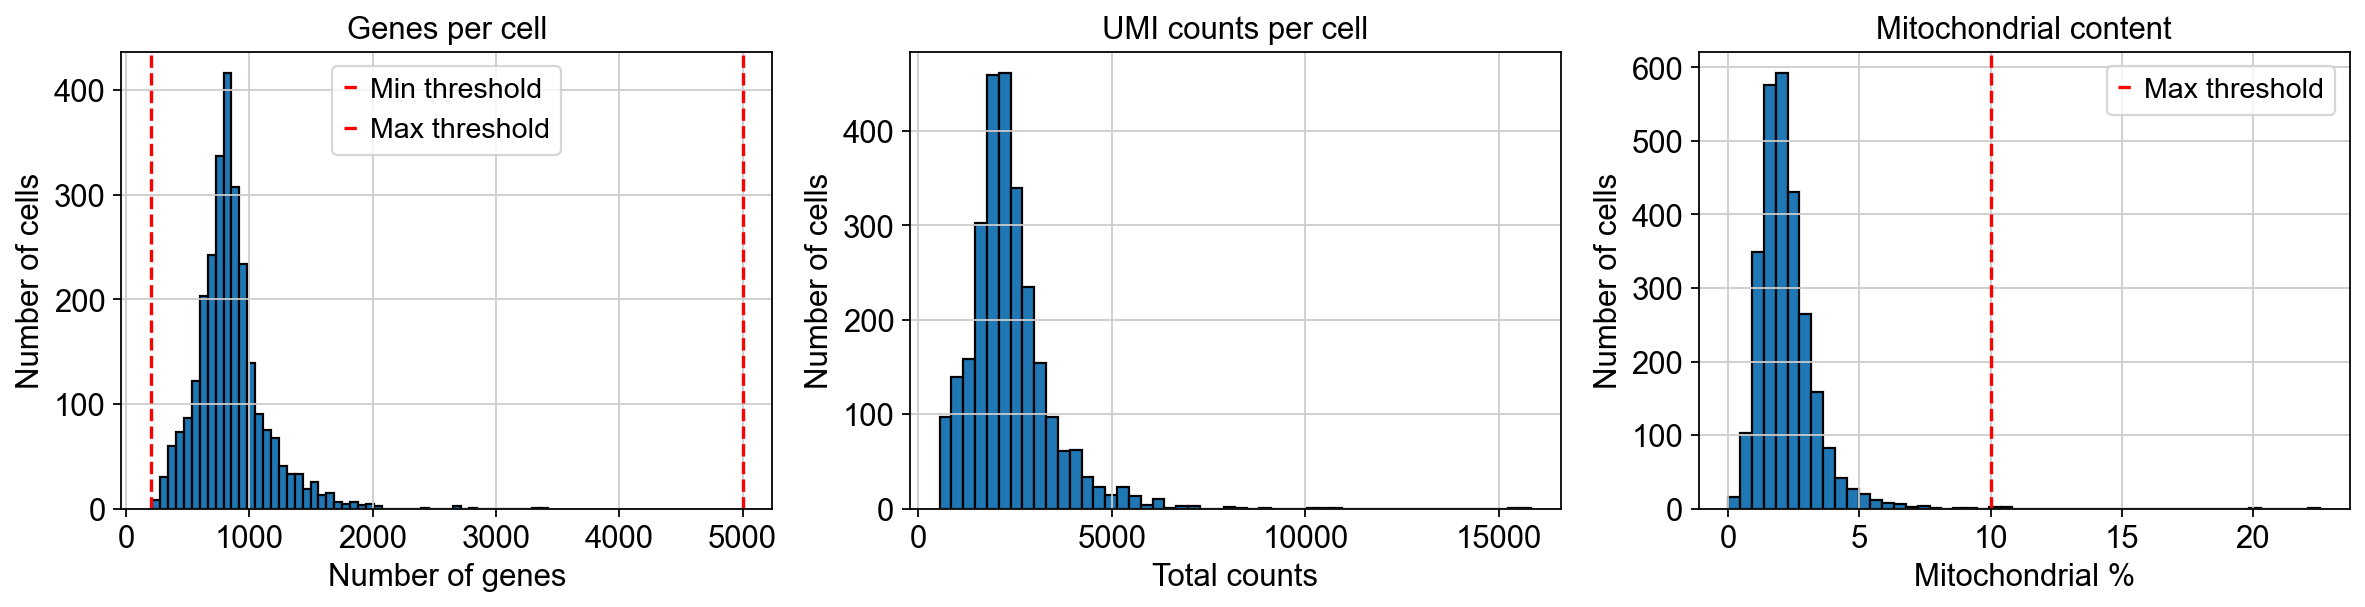

In [9]:
# Visualize QC metrics
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot 1: Number of genes per cell
axes[0].hist(adata.obs['n_genes_by_counts'], bins=50, edgecolor='black')
axes[0].set_xlabel('Number of genes')
axes[0].set_ylabel('Number of cells')
axes[0].set_title('Genes per cell')
axes[0].axvline(config['preprocessing']['min_genes_per_cell'], color='r', linestyle='--', label='Min threshold')
axes[0].axvline(config['preprocessing']['max_genes_per_cell'], color='r', linestyle='--', label='Max threshold')
axes[0].legend()

# Plot 2: Total counts per cell
axes[1].hist(adata.obs['total_counts'], bins=50, edgecolor='black')
axes[1].set_xlabel('Total counts')
axes[1].set_ylabel('Number of cells')
axes[1].set_title('UMI counts per cell')

# Plot 3: Mitochondrial percentage
axes[2].hist(adata.obs['pct_counts_mt'], bins=50, edgecolor='black')
axes[2].set_xlabel('Mitochondrial %')
axes[2].set_ylabel('Number of cells')
axes[2].set_title('Mitochondrial content')
axes[2].axvline(config['preprocessing']['max_mito_percent'], color='r', linestyle='--', label='Max threshold')
axes[2].legend()

plt.tight_layout()
plt.show()

## Filtering

Filter cells and genes based on QC thresholds.

In [10]:
print(f"Before filtering: {adata.shape[0]} cells x {adata.shape[1]} genes")

# Filter cells
sc.pp.filter_cells(adata, min_genes=config['preprocessing']['min_genes_per_cell'])
sc.pp.filter_cells(adata, max_genes=config['preprocessing']['max_genes_per_cell'])

# Filter based on mitochondrial content
adata = adata[adata.obs['pct_counts_mt'] < config['preprocessing']['max_mito_percent'], :].copy()

# Filter genes
sc.pp.filter_genes(adata, min_cells=config['preprocessing']['min_cells_per_gene'])

print(f"After filtering: {adata.shape[0]} cells x {adata.shape[1]} genes")

Before filtering: 2700 cells x 32738 genes
filtered out 19026 genes that are detected in less than 3 cells
After filtering: 2694 cells x 13712 genes


## Normalization

Normalize counts and log-transform.

In [11]:
# Store raw counts
adata.layers['counts'] = adata.X.copy()

# Normalize to target sum
sc.pp.normalize_total(adata, target_sum=config['preprocessing']['target_sum'])

# Log transform
sc.pp.log1p(adata)

# Store normalized data
adata.layers['log1p_norm'] = adata.X.copy()

print("Normalization complete")

normalizing counts per cell


    finished (0:00:03)
Normalization complete


## Highly Variable Genes

Identify genes with high variability across cells.

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
Identified 2000 highly variable genes


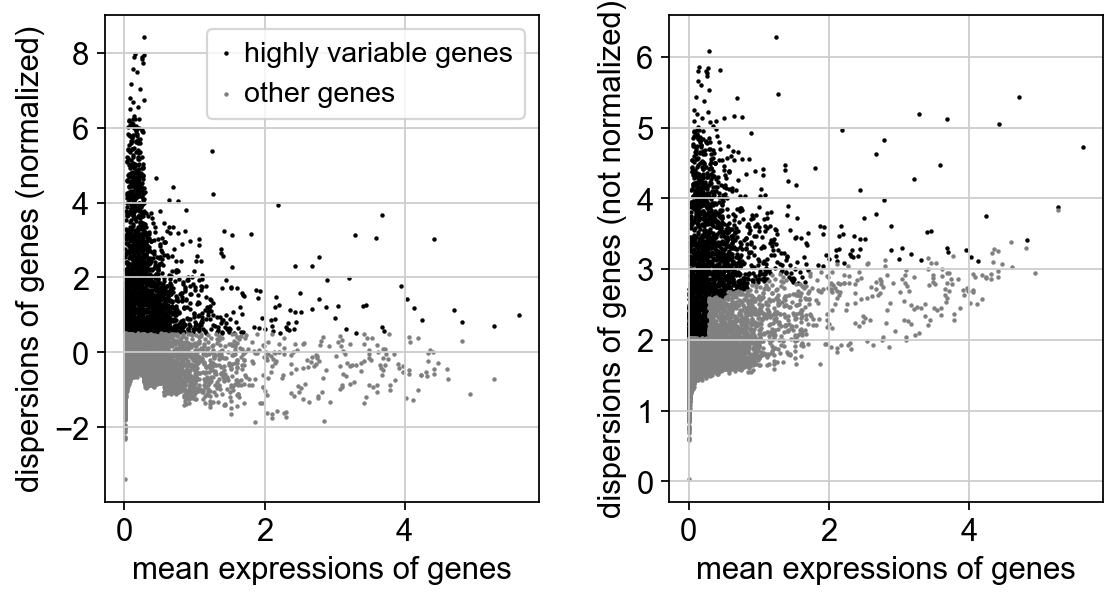

In [12]:
# Identify highly variable genes
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=config['normalization']['highly_variable_genes'],
    subset=False,
    flavor='seurat'
)

print(f"Identified {adata.var['highly_variable'].sum()} highly variable genes")

# Visualize
sc.pl.highly_variable_genes(adata)

## Scaling and PCA

Scale data and perform dimensionality reduction.

In [13]:
# Scale data
sc.pp.scale(adata, max_value=config['normalization']['scale_max'])

# Perform PCA
sc.tl.pca(adata, n_comps=config['cell_annotation']['n_pcs'], svd_solver='arpack')

print("PCA complete")

c:\Users\dell\anaconda3\Lib\functools.py:907: UserWarning: zero-centering a sparse array/matrix densifies it.
  '1 positional argument')


computing PCA
    with n_comps=50
    finished (0:00:02)
PCA complete


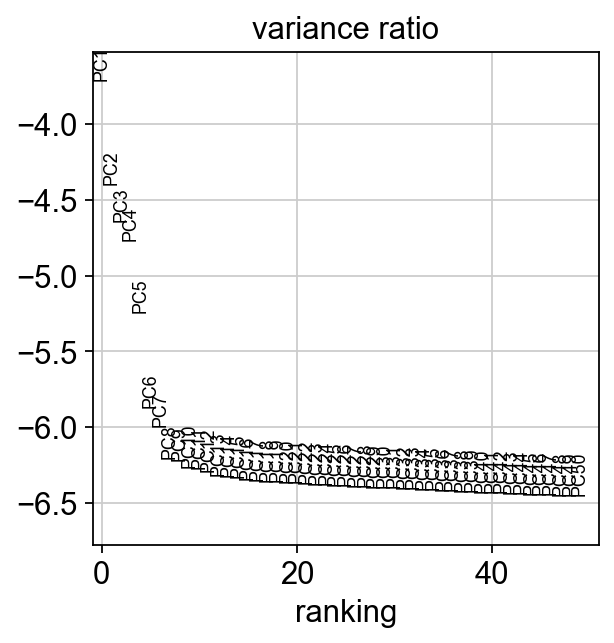

In [14]:
# Visualize PCA variance
sc.pl.pca_variance_ratio(adata, log=True, n_pcs=50)

## Save Processed Data

In [15]:
# Save processed data
output_file = '../data/processed/preprocessed_data.h5ad'
adata.write(output_file, compression='gzip')

print(f"Saved processed data to {output_file}")
print(f"Final dataset: {adata.shape[0]} cells x {adata.shape[1]} genes")

Saved processed data to ../data/processed/preprocessed_data.h5ad
Final dataset: 2694 cells x 13712 genes


## Next Steps

Proceed to notebook `02_cell_type_annotation.ipynb` for clustering and cell type identification.